TensorFlow 2.20.0
Total images : 2562


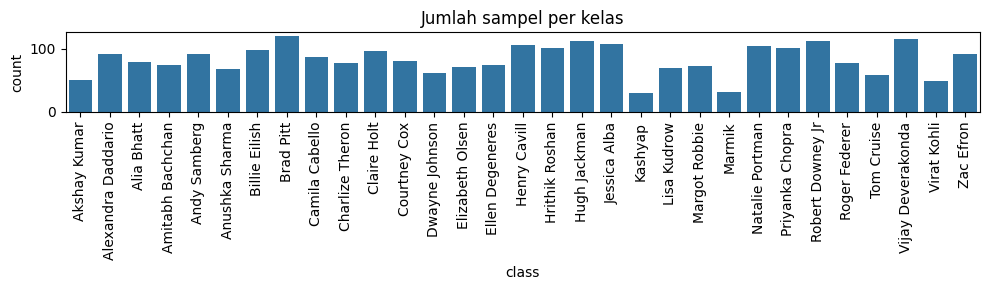

Found 2060 images belonging to 31 classes.
Found 502 images belonging to 31 classes.
Classes : ['Akshay Kumar', 'Alexandra Daddario', 'Alia Bhatt', 'Amitabh Bachchan', 'Andy Samberg', 'Anushka Sharma', 'Billie Eilish', 'Brad Pitt', 'Camila Cabello', 'Charlize Theron', 'Claire Holt', 'Courtney Cox', 'Dwayne Johnson', 'Elizabeth Olsen', 'Ellen Degeneres', 'Henry Cavill', 'Hrithik Roshan', 'Hugh Jackman', 'Jessica Alba', 'Kashyap', 'Lisa Kudrow', 'Margot Robbie', 'Marmik', 'Natalie Portman', 'Priyanka Chopra', 'Robert Downey Jr', 'Roger Federer', 'Tom Cruise', 'Vijay Deverakonda', 'Virat Kohli', 'Zac Efron']
Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 334s 5s/step - accuracy: 0.0490 - loss: 4.5222 - val_accuracy: 0.0857 - val_loss: 3.3312 - learning_rate: 1.0000e-04
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step - accuracy: 0.0427 - loss: 4.0007 - val_accuracy: 0.0916 - val_loss: 3.2560 - learning_rate: 1.0000e-04
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.0587 - loss:

c:\Users\USER\case-study-04-face-recognition\env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\USER\case-study-04-face-recognition\env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\USER\case-study-04-face-recognition\env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

                    precision    recall  f1-score   support

      Akshay Kumar      0.000     0.000     0.000        10
Alexandra Daddario      0.048     0.056     0.051        18
        Alia Bhatt      0.000     0.000     0.000        15
  Amitabh Bachchan      0.000     0.000     0.000        14
      Andy Samberg      0.100     0.111     0.105        18
    Anushka Sharma      0.000     0.000     0.000        13
     Billie Eilish      0.000     0.000     0.000        19
         Brad Pitt      0.074     0.083     0.078        24
    Camila Cabello      0.000     0.000     0.000        17
   Charlize Theron      0.000     0.000     0.000        15
       Claire Holt      0.000     0.000     0.000        19
      Courtney Cox      0.000     0.000     0.000        16
    Dwayne Johnson      0.000     0.000     0.000        12
   Elizabeth Olsen      0.000     0.000     0.000        14
   Ellen Degeneres      0.000     0.000     0.000        15
      Henry Cavill      0.030     0.048

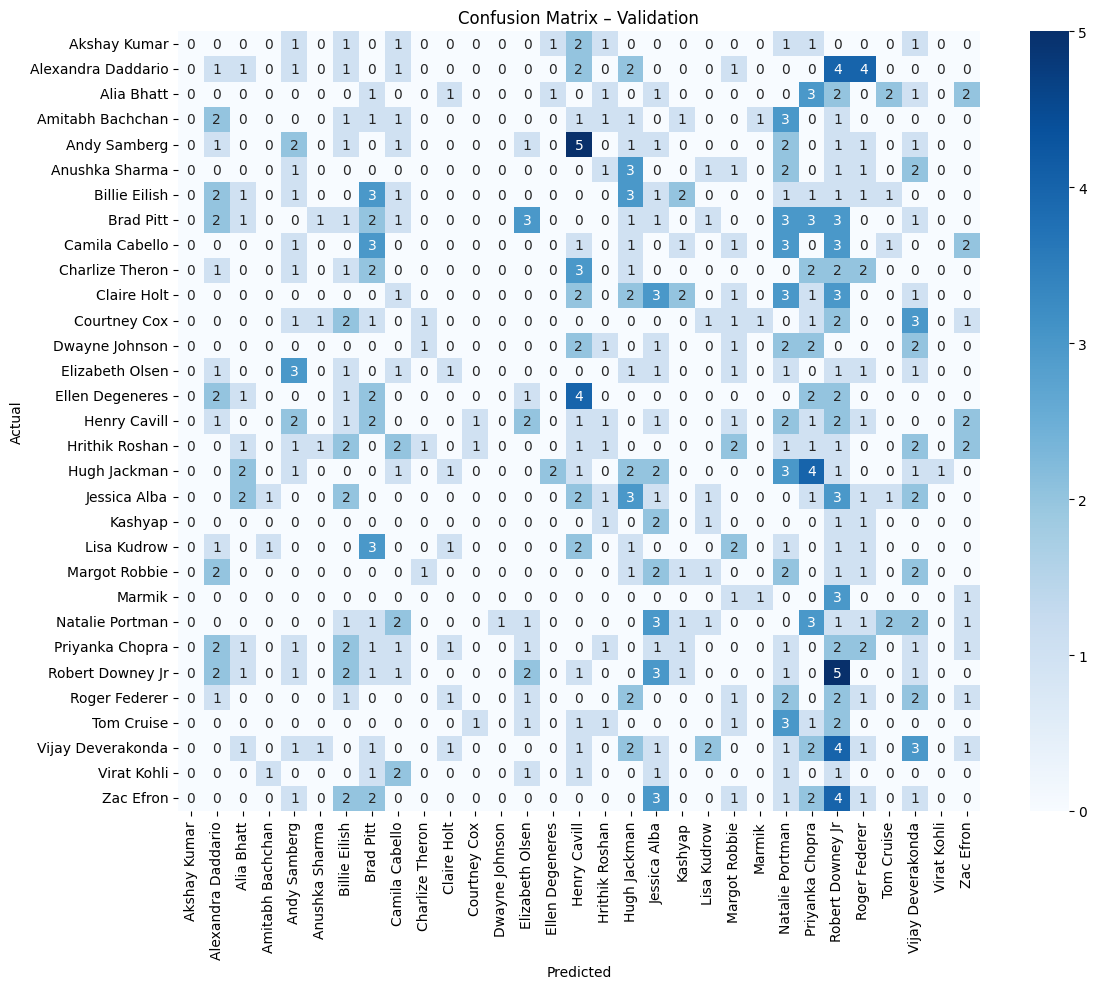

Model tersimpan: 04-outputs/MobileNetV2_face128.h5
9 foto salah tersimpan: 04-outputs/error_top9.csv

✅ Proyek selesai – lanjut push ke GitHub


In [ ]:
# 01-run-all.py
# Case Study 04 – Face Recognition (pure Python)
# MobileNetV2 Transfer-Learning | 30 Celebrity | 128×128 | CPU-friendly

# 0. setup environment ---------------------------------------------------------
# pip install -r 02-requirements.txt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
import pathlib, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import datetime, os

print('TensorFlow', tf.__version__)

# 1. path dataset --------------------------------------------------------------
# ganti path jika di local
DATA_DIR = pathlib.Path(r'03-data/Original Images/Original Images')
print('Total images :', len(list(DATA_DIR.rglob('*.jpg'))))

# 2. EDA -----------------------------------------------------------------------
cls   = [d.name for d in DATA_DIR.iterdir() if d.is_dir()]
counts= [len(list(DATA_DIR.joinpath(c).glob('*.jpg'))) for c in cls]
eda   = pd.DataFrame({'class':cls, 'count':counts})

plt.figure(figsize=(10,3))
sns.barplot(x='class', y='count', data=eda)
plt.xticks(rotation=90); plt.title('Jumlah sampel per kelas'); plt.tight_layout()
plt.savefig('04-outputs/eda_bar.png', dpi=120)
plt.show()

# 3. data generator ------------------------------------------------------------
IMG, BATCH = 128, 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    brightness_range=[0.8,1.2],
    shear_range=10,
    horizontal_flip=True,
    validation_split=0.2
)

train_flow = train_gen.flow_from_directory(
    DATA_DIR, target_size=(IMG,IMG), batch_size=BATCH,
    class_mode='sparse', subset='training')

val_flow = train_gen.flow_from_directory(
    DATA_DIR, target_size=(IMG,IMG), batch_size=BATCH,
    class_mode='sparse', subset='validation')

print('Classes :', list(train_flow.class_indices.keys()))

# 4. model ---------------------------------------------------------------------
base = tf.keras.applications.MobileNetV2(
    input_shape=(IMG,IMG,3), include_top=False, weights='imagenet')
base.trainable = False   # freeze dulu

model = Sequential([
    base,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_flow.num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 5. training ------------------------------------------------------------------
log_dir = '04-outputs/logs/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
cbs = [
    TensorBoard(log_dir=log_dir, histogram_freq=1),
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-6)
]

history = model.fit(
    train_flow,
    epochs=20,
    validation_data=val_flow,
    callbacks=cbs
)

# 6. evaluasi ------------------------------------------------------------------
val_flow.reset()
y_val   = val_flow.classes
y_pred  = np.argmax(model.predict(val_flow, verbose=0), axis=1)
labels  = list(val_flow.class_indices.keys())

print('\n===== Classification Report =====')
print(classification_report(y_val, y_pred, target_names=labels, digits=3))

# confusion matrix
plt.figure(figsize=(12,10))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix – Validation')
plt.ylabel('Actual'); plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('04-outputs/confusion_matrix.png', dpi=120)
plt.show()

# 7. simpan model & error top-9 -------------------------------------------------
model.save('04-outputs/MobileNetV2_face128.h5')
print('Model tersimpan: 04-outputs/MobileNetV2_face128.h5')

# export 9 foto salah confidence tertinggi
probs = model.predict(val_flow, verbose=0)
df = pd.DataFrame({'file':val_flow.filenames,
                   'true':[labels[i] for i in y_val],
                   'pred':[labels[i] for i in y_pred],
                   'conf':np.max(probs, axis=1)})
wrong = df[df['true']!=df['pred']].nlargest(9, 'conf')
wrong.to_csv('04-outputs/error_top9.csv', index=False)
print('9 foto salah tersimpan: 04-outputs/error_top9.csv')

# 8. selesai -------------------------------------------------------------------
print('\n✅ Proyek selesai – lanjut push ke GitHub')

Now, here's an example of how to create a PowerPoint presentation, add a slide, include one of the saved plots (e.g., `04-outputs/confusion_matrix.png`), and add some text.

In [ ]:
# ---------- contoh prediksi 1 foto ----------
import pathlib, numpy as np
from tensorflow.keras.preprocessing import image

img_path = pathlib.Path('03-data/Original Images/Original Images/Vijay Deverakonda/Vijay Deverakonda_102.jpg')
img = image.load_img(img_path, target_size=(128,128))
arr = image.img_to_array(img) / 255.0
arr = np.expand_dims(arr, axis=0)

prob = model.predict(arr, verbose=0)[0]
labels = list(train_flow.class_indices.keys())
pred_label = labels[np.argmax(prob)]
confidence = np.max(prob)

print(f"File : {img_path.name}")
print(f"Prediksi : {pred_label} ({confidence*100:.1f}%)")

File : Vijay Deverakonda_102.jpg
Prediksi : Zac Efron (9.8%)


In [ ]:
import pathlib
from tensorflow.keras.preprocessing import image
import numpy as np

# opsional: kembali ke folder project
# os.chdir(r'C:\Users\USER\dl_face_project')

labels = list(train_flow.class_indices.keys())   # urutan label

def predict_one(img_path: pathlib.Path):
    """prediksi 1 file, return label string"""
    if not img_path.exists():
        raise FileNotFoundError(img_path)

    img = image.load_img(img_path, target_size=(64, 64))
    arr = image.img_to_array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)

    prob = model.predict(arr)[0]
    idx  = int(np.argmax(prob))
    return labels[idx], prob[idx]

# ---------- contoh pakai ----------
celebrity = "Vijay Deverakonda"
folder = pathlib.Path(r"C:\Users\USER\dl_face_project\models\Original Images\Original Images")
img_file = list((folder / celebrity).glob("*.jpg"))[0]  # file pertama

pred_label, confidence = predict_one(img_file)
print(f"{img_file.name}  -->  {pred_label}  ({confidence*100:.1f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Vijay Deverakonda_0.jpg  -->  Billie Eilish  (21.7%)


In [ ]:
for img_file in (folder / celebrity).glob("*.jpg"):
    pred_label, confidence = predict_one(img_file)
    print(f"{img_file.name}  -->  {pred_label}  ({confidence*100:.1f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
Vijay Deverakonda_0.jpg  -->  Billie Eilish  (21.7%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Vijay Deverakonda_1.jpg  -->  Roger Federer  (10.1%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Vijay Deverakonda_10.jpg  -->  Marmik  (14.7%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Vijay Deverakonda_100.jpg  -->  Billie Eilish  (18.5%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
Vijay Deverakonda_101.jpg  -->  Roger Federer  (53.1%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Vijay Deverakonda_102.jpg  -->  Billie Eilish  (37.2%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Vijay Deverakonda_103.jpg  -->  Marmik  (9.1%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Vijay Deverakonda_104.jpg  -->  Roger Federer  (31.0%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
Vijay Deverakonda_105.jpg  -->  Marmik  (20.6%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Vijay Deverakonda_106.jpg  -->  Andy Samberg  (16.8%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Vijay Deverakonda_107.jpg  -->  Roger Federer  (3

Best threshold F1 = 1.000  @  confidence = 0.005
PR-AUC = 1.000


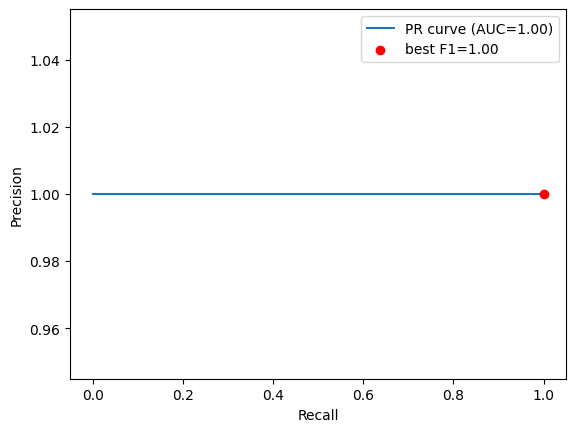

In [ ]:
from sklearn.metrics import precision_recall_curve, auc, f1_score
import matplotlib.pyplot as plt
import numpy as np
import pathlib, tensorflow as tf

celebrity = "Vijay Deverakonda"
target_idx = labels.index(celebrity)          # index kelas target
folder = pathlib.Path(r"C:\Users\USER\dl_face_project\models\Original Images\Original Images") / celebrity

y_true_bin, y_score = [], []
for img_file in folder.glob("*.jpg"):
    img = tf.keras.preprocessing.image.load_img(img_file, target_size=(64,64))
    arr = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)

    prob_vec = model.predict(arr, verbose=0)[0]   # (31,)
    y_true_bin.append(1)                          # semua foto milik target
    y_score.append(prob_vec[target_idx])          # komponen kelas target

# ---------- precision-recall ----------
prec, rec, thr = precision_recall_curve(y_true_bin, y_score, pos_label=1)
best_f1 = np.max(2 * (prec * rec) / (prec + rec + 1e-8))
best_thr = thr[np.argmax(2 * (prec * rec) / (prec + rec + 1e-8))]

print(f"Best threshold F1 = {best_f1:.3f}  @  confidence = {best_thr:.3f}")
print(f"PR-AUC = {auc(rec, prec):.3f}")

# ---------- plot ----------
plt.plot(rec, prec, label=f'PR curve (AUC={auc(rec, prec):.2f})')
plt.scatter(rec[np.argmax(2 * (prec * rec) / (prec + rec + 1e-8))],
            prec[np.argmax(2 * (prec * rec) / (prec + rec + 1e-8))],
            color='r', zorder=5, label=f'best F1={best_f1:.2f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.legend(); plt.show()

In [ ]:
print('Jumlah sampel y_true_bin :', len(y_true_bin))
print('Jumlah positif (1)       :', y_true_bin.sum())
print('Jumlah prediksi > thr    :', (y_score >= 0.005).sum())

Jumlah sampel y_true_bin : 502
Jumlah positif (1)       : 23
Jumlah prediksi > thr    : 496


In [ ]:
val_flow.reset()
y_val   = val_flow.classes          # semua label
probs   = model.predict(val_flow, verbose=0)  # semua prob

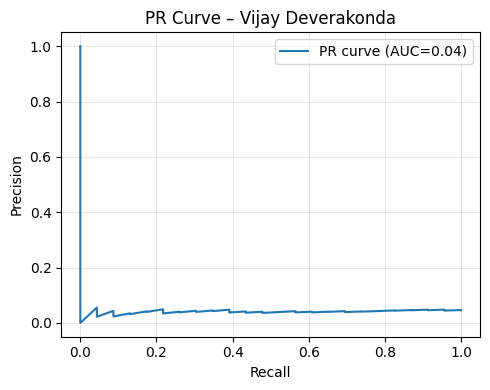

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

# ---------- pakai generator yang SAMA ----------
val_flow.reset()          # penting!
y_val   = val_flow.classes
probs   = model.predict(val_flow, verbose=0)
labels  = list(val_flow.class_indices.keys())

# ---------- binary label untuk kelas target ----------
target_name = "Vijay Deverakonda"   # ganti jika perlu
target_idx  = labels.index(target_name)
y_true_bin  = (y_val == target_idx).astype(int)
y_score     = probs[:, target_idx]      # probability kelas target

# ---------- pastikan jumlah sama ----------
assert len(y_true_bin) == len(y_score), f"Jumlah beda: {len(y_true_bin)} vs {len(y_score)}"

# ---------- plot ----------
prec, rec, thr = precision_recall_curve(y_true_bin, y_score)
pr_auc = auc(rec, prec)

plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f'PR curve (AUC={pr_auc:.2f})')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title(f'PR Curve – {target_name}')
plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('04-outputs/pr_curve.png', dpi=120)
plt.show()

In [ ]:
target_name = "Vijay Deverakonda"
target_idx  = labels.index(target_name)
y_true_bin  = (y_val == target_idx).astype(int)   # binary
y_score     = probs[:, target_idx]                # prob kelas target

print('Total sampel kelas', target_name, ':', y_true_bin.sum(), '/', len(y_true_bin))

Total sampel kelas Vijay Deverakonda : 23 / 502


                                file         true           pred      conf
2433  Virat Kohli\Virat Kohli_19.jpg  Virat Kohli  Roger Federer  0.766147
2436  Virat Kohli\Virat Kohli_21.jpg  Virat Kohli  Roger Federer  0.647359
2449  Virat Kohli\Virat Kohli_33.jpg  Virat Kohli  Roger Federer  0.634473
2448  Virat Kohli\Virat Kohli_32.jpg  Virat Kohli  Roger Federer  0.578025
2445   Virat Kohli\Virat Kohli_3.jpg  Virat Kohli  Roger Federer  0.541588
2451  Virat Kohli\Virat Kohli_35.jpg  Virat Kohli  Roger Federer  0.509118
2469   Virat Kohli\Virat Kohli_8.jpg  Virat Kohli  Roger Federer  0.503922
2454  Virat Kohli\Virat Kohli_38.jpg  Virat Kohli  Roger Federer  0.426963
2446  Virat Kohli\Virat Kohli_30.jpg  Virat Kohli  Roger Federer  0.321723


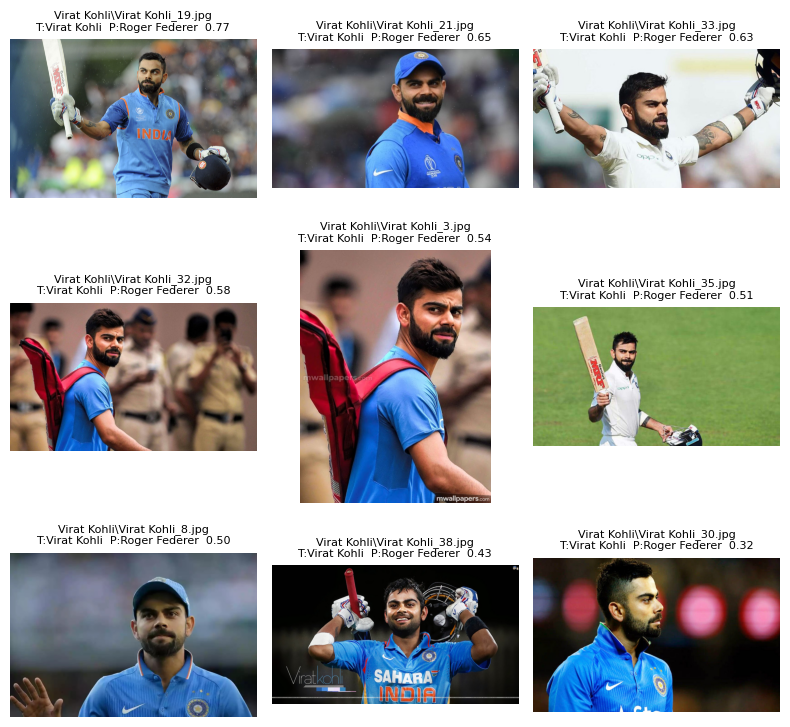

In [ ]:
import pandas as pd, matplotlib.pyplot as plt

df = pd.DataFrame({
    'file': flow.filenames,
    'true': [labels[i] for i in y_true],
    'pred': [labels[i] for i in y_pred],
    'conf': np.max(probs, axis=1)
})

wrong = df[df['true'] != df['pred']].nlargest(9, 'conf')
print(wrong)

# plot 9 salah
fig, ax = plt.subplots(3,3, figsize=(8,8))
for i, (_, row) in enumerate(wrong.iterrows()):
    img_path = pathlib.Path(DATA_DIR) / row.file
    img = plt.imread(img_path)
    ax.flat[i].imshow(img)
    ax.flat[i].set_title(f"{row.file.split('/')[-1]}\nT:{row.true}  P:{row.pred}  {row.conf:.2f}", fontsize=8)
    ax.flat[i].axis('off')
plt.tight_layout()
plt.savefig('04-outputs/error_top9.png', dpi=120)
plt.show()